# Feature preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv("train.csv", sep=",")
X_t = pd.read_csv("test.csv", sep=",")
print(data.shape, X_t.shape)
data.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Смотрим, где у нас отсутствуют данные
t = data.isnull().sum()
t[t>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [4]:
#Делим данные на целевую переменную и фичи, и смотрим целевую переменную
X = data.drop(['SalePrice','Id'], axis = 1)
id_test = X_t['Id']
X_t = X_t.drop(['Id'], axis = 1)
y = data['SalePrice']
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
#Ищем колонки с категориальными фичами
t = X.dtypes
categ = t[t == 'object'].index
#t.value_counts()


<Figure size 432x288 with 0 Axes>

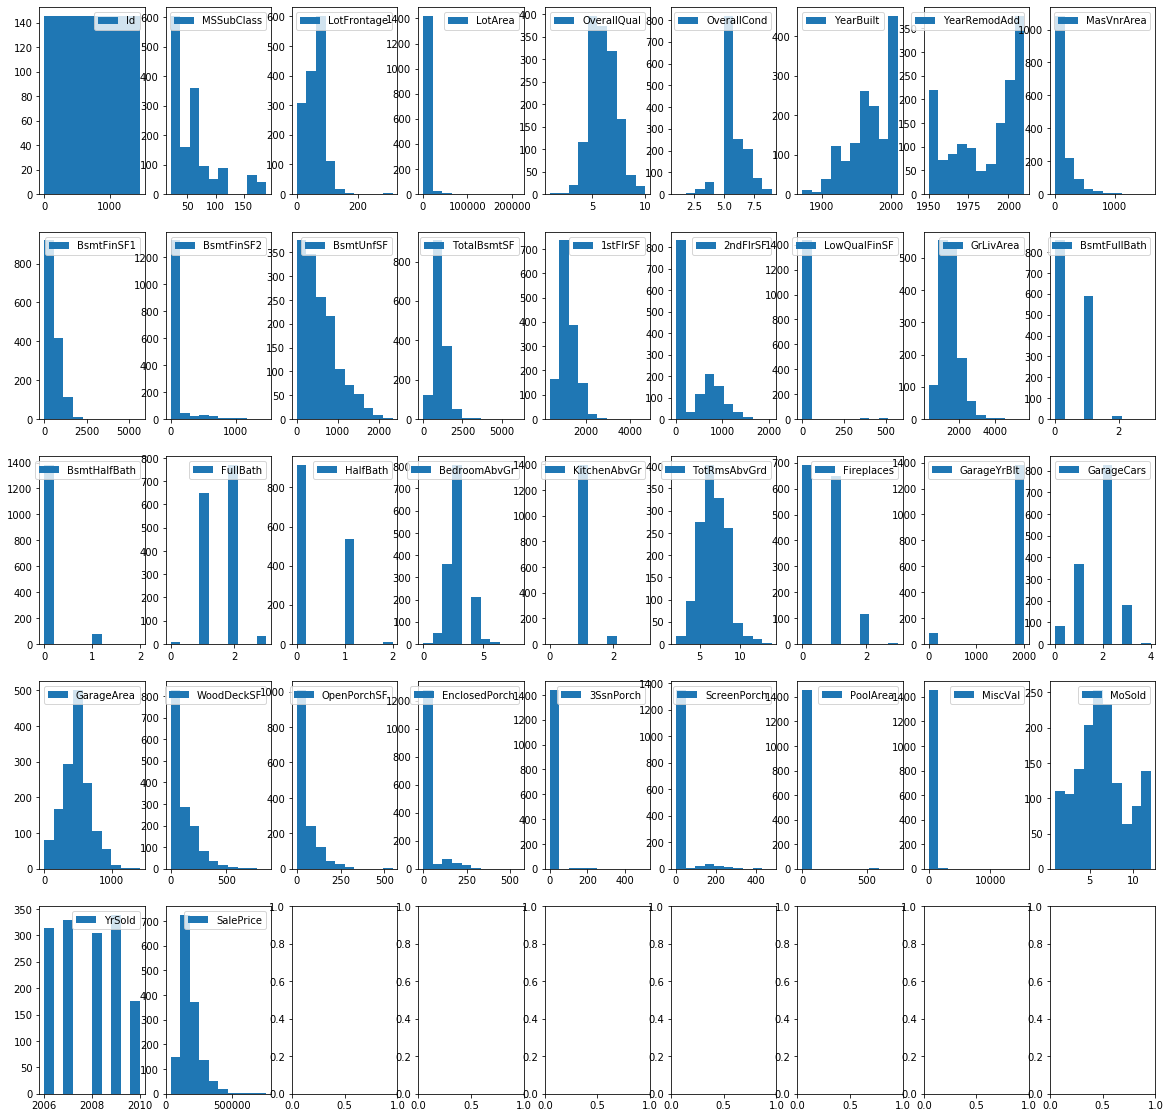

In [6]:
plt.clf()
fig,ax=plt.subplots(5,9,figsize=(20,20))
c=0
r=0
for col in data.columns:
    # print(col)
    if col in categ: continue
    if data[col].dtype=='O':continue
    ax[r,c].hist(data[col].fillna(0), label=col)
    ax[r,c].legend()
    if c<8: 
        c+=1
    else: 
        c=0
        r+=1
plt.show()

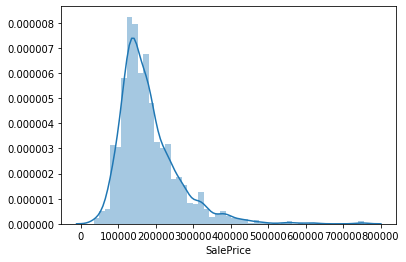

In [7]:
sns.distplot(y)

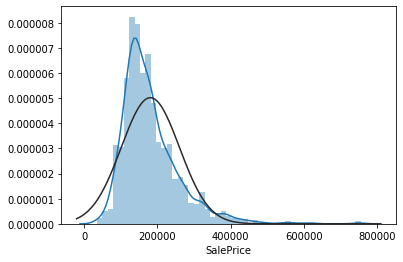

In [8]:
#Нормализуем Y и строим новый график
y_log = np.log(y)
sns.distplot(y, fit = norm)

In [9]:
replacements = {
    'PoolQC':{'map':{'Gd': 3, 'Ex': 4, 'Fa': 1, 'Ta': 2}, 'FillNA': 0},
    'Fence':{'map':{'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}, 'FillNA': 0},
    'FireplaceQu':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'FillNA': 0},
    'Electrical':{'FillNA': 'SBrkr'},
    'BsmtQual':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},'FillNA': 0},
    'BsmtCond':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},'FillNA': 0},
    'MasVnrType':{'map':{'None': 'NA'}, 'FillNA': 'NA'},
    'GarageYrBlt':{'FillNA': 1800},
}



In [10]:
def replace(df):
    res = pd.DataFrame()
    for c in df.columns:
        #print(c)
        if c in replacements.keys():
            if 'map' in replacements[c]:
                res[c] = df[c].map(replacements[c]['map']).fillna(replacements[c]['FillNA'])
            else:
                res[c] = df[c].fillna(replacements[c]['FillNA'])
        else:
            if df.dtypes[c] == 'object':
                res[c] = df[c].fillna('NA')
            else:
                res[c] = df[c].fillna(0)
                
    res['Pool'] = res['PoolQC'] > 0
    res['Garage'] = res['GarageType']!= 'NA'
    return res

In [11]:
X = replace(X)
print(X.head(), X.isnull().sum().sum())
# print(X['Fence'].value_counts())

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig  ... PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    Inside  ...    0.0   0.0          NA       0   
1         Lvl    AllPub       FR2  ...    0.0   0.0          NA       0   
2         Lvl    AllPub    Inside  ...    0.0   0.0          NA       0   
3         Lvl    AllPub    Corner  ...    0.0   0.0          NA       0   
4         Lvl    AllPub       FR2  ...    0.0   0.0          NA       0   

  MoSold YrSold  SaleType  SaleCondition   Pool  Garage  
0      2   2008        WD         Normal  False    True  
1      5   2

In [12]:
X_t = replace(X_t)
print(X_t.isnull().sum().sum())
# print(X_t['Fence'].value_counts())

0


In [13]:
c = X[categ]
c.shape
c.head(10)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,0.0,0.0,NA,WD,Abnorml
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
5,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Attchd,Unf,TA,TA,Y,0.0,3.0,Shed,WD,Normal
6,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
7,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,Attchd,RFn,TA,TA,Y,0.0,0.0,Shed,WD,Normal
8,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,Fa,TA,Y,0.0,0.0,NA,WD,Abnorml
9,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,Attchd,RFn,Gd,TA,Y,0.0,0.0,NA,WD,Normal


In [14]:
#Преобразовываем категориальные фичи
ohe = OneHotEncoder(sparse = False, categories = 'auto', handle_unknown = 'ignore')
c2 = ohe.fit_transform(c)
ohe.get_feature_names()
c3 = pd.DataFrame(c2, index = c.index, columns = ohe.get_feature_names())
c3.head()
X = pd.concat([X.drop(c.columns, axis = 1),c3], axis = 1)
X.shape


(1460, 301)

In [15]:
#И повторяем для теста
c_test = X_t[categ]
print(c_test.shape)
c_test.head(10)

(1459, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,Attchd,Unf,TA,TA,Y,0.0,3.0,NA,WD,Normal
1,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,0.0,0.0,Gar2,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,0.0,3.0,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,0.0,0.0,NA,WD,Normal
4,RL,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,Attchd,RFn,TA,TA,Y,0.0,0.0,NA,WD,Normal
5,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,0.0,0.0,NA,WD,Normal
6,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,0.0,4.0,Shed,WD,Normal
7,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,0.0,0.0,NA,WD,Normal
8,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Unf,TA,TA,Y,0.0,0.0,NA,WD,Normal
9,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,0.0,3.0,NA,WD,Normal


In [16]:
c2_test = ohe.transform(c_test)
c3_test = pd.DataFrame(c2_test, index = c_test.index, columns = ohe.get_feature_names())
c3_test.head()
X_t = pd.concat([X_t.drop(c.columns, axis = 1),c3_test], axis = 1)
X_t.shape

(1459, 301)

# Boosting!


In [17]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [18]:
X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, np.array(y))
print(X_train.shape)

(1095, 301)


In [19]:
y_train = np.log(y_train_orig)
y_test = np.log(y_test_orig)

In [20]:
pl = Pipeline([
    #( 'scaler', RobustScaler()),
    ('xgb', xgb.XGBRegressor())])

In [21]:
param_grid = {
    'xgb__n_estimators': [500, 700, 800],
    'xgb__colsample_bytree': [0.7],
    'xgb__max_depth': [2, 3 ,5],
    'xgb__reg_alpha': [0.03],
    'xgb__reg_lambda': [0.2],
    'xgb__subsample': [0.7],
    #'tree_method': ["hist", 'exact', 'approx']
    'xgb__learning_rate': [0.05],
    
    #'xgb__feature_selector': ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']
    #'xgb__booster': ['gbtree', 'gblinear', 'dart']
    }

In [22]:
np.random.seed(42)
gs = GridSearchCV(estimator=pl, param_grid=param_grid, cv=10,
                  n_jobs=-1, scoring='neg_mean_squared_error',verbose=3)

In [23]:
gs.fit(X_train, y_train)
print(np.sqrt(-gs.best_score_))
print(gs.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


[20:27:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12489540119382132
{'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 800, 'xgb__reg_alpha': 0.03, 'xgb__reg_lambda': 0.2, 'xgb__subsample': 0.7}


In [24]:
y_pred = gs.predict(X_test)
t = mean_squared_error(y_pred, y_test)
t1 = mean_squared_error(np.exp(y_pred), np.exp(y_test))
print(t, np.sqrt(t), t1, np.sqrt(t1))

0.013981702481283553 0.11824424925248396 514019355.41283995 22671.994958821775


In [25]:
y_test_pred = gs.predict(X_t)
print(y_test_pred[0:10], np.exp(y_test_pred)[:10], np.exp(y_test_pred.mean()))

[11.724748 11.980497 12.16851  12.187421 12.147349 12.074781 12.066826
 12.030003 12.108548 11.773393] [123592.81 159611.39 192626.9  196304.22 188593.53 175392.47 174002.66
 167711.84 181416.03 129753.62] 164270.81


In [26]:
# готовим файл для сабмита на Каггл
my_submission = pd.DataFrame({'Id': id_test, 'SalePrice': np.exp(y_test_pred)})
my_submission.to_csv('submission.csv', index=False)

# NN model

In [27]:
def nn_model():
	# create model
	model = Sequential()
	model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [28]:
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=nn_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))













Standardized: -1.98 (0.33) MSE


In [29]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
t = mean_squared_error(y_pred, y_test)
t1 = mean_squared_error(np.exp(y_pred), np.exp(y_test))
print(t, np.sqrt(t), t1, np.sqrt(t1))

1.8958889485467414 1.3769128325884472 17595437568.67119 132647.79518963437


In [30]:
y_test_pred = pipeline.predict(X_t)
print(y_test_pred[0:10], np.exp(y_test_pred)[:10], np.exp(y_test_pred.mean()))

[10.255694  9.366026 11.810561 11.483401 11.706654 11.75782  11.89278
 11.736917 11.466661 11.877851] [ 28444.053  11684.587 134667.11   97090.74  121376.625 127748.67
 146207.23  125105.984  95478.984 144040.61 ] 96575.35


In [31]:
# готовим файл для сабмита на Каггл
my_submission = pd.DataFrame({'Id': id_test, 'SalePrice': np.exp(y_test_pred)})
my_submission.to_csv('submission_nn.csv', index=False)